# Grade: /100 pts
# Assignment 9: FATE Machine Learning

## Student ID: 250979448

In this coursework, we will study how to make a complex non-linear model more interpretable and we will study any fairness issues that may arise when using AI models to solve organizational problems.

Our problem will be credit card default prediction, a well-known application of machine learning that most financial institutions and payment processors deploy to decide creditworthiness. Normally, financial institutions use linear models such as logistic regression to create these models, but non-linear (and less explainable) methods are tempting as they have strong predictive abilities. In this coursework, we'll create one of such models and study what issues arise. The following questions first develop a model, then we study how to make it more interpretable, and finally, we discuss any fairness issues that arise.

In [1]:
# Install SHAP if needed
# !pip install shap

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve,roc_auc_score

from xgboost import XGBClassifier
import shap

In [3]:
# Download the data directly
# !gdown https://drive.google.com/uc?id=1sqKxJeJhLA2BaEVnCqXcLWZ5oSfyVP56

For this assignment, we will use a credit card default dataset. For further information about the data, refer to: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

**Variable explanations:**

**ID:** ID of each client.

**LIMIT_BAL:** Amount of given credit in NT dollars (includes individual and family/supplementary credit).

**SEX:** Gender reported to the company (1=male, 2=female).

**EDUCATION:** (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown).

**MARRIAGE:** Marital status (1=married, 2=single, 3=others).

**AGE:** Age in years.

**PAY_0:** Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, â€¦ 8=payment delay for eight months, 9=payment delay for nine months and above).

**PAY_2:** Repayment status in August, 2005 (scale same as above).

**PAY_3:** Repayment status in July, 2005 (scale same as above).

**PAY_4:** Repayment status in June, 2005 (scale same as above).

**PAY_5:** Repayment status in May, 2005 (scale same as above).

**PAY_6:** Repayment status in April, 2005 (scale same as above).

**BILL_AMT1:** Amount of bill statement in September, 2005 (NT dollar).

**BILL_AMT2:** Amount of bill statement in August, 2005 (NT dollar).

**BILL_AMT3:** Amount of bill statement in July, 2005 (NT dollar).

**BILL_AMT4:** Amount of bill statement in June, 2005 (NT dollar).

**BILL_AMT5:** Amount of bill statement in May, 2005 (NT dollar).

**BILL_AMT6:** Amount of bill statement in April, 2005 (NT dollar).

**PAY_AMT1:** Amount of previous payment in September, 2005 (NT dollar).

**PAY_AMT2:** Amount of previous payment in August, 2005 (NT dollar).

**PAY_AMT3:** Amount of previous payment in July, 2005 (NT dollar).

**PAY_AMT4:** Amount of previous payment in June, 2005 (NT dollar).

**PAY_AMT5:** Amount of previous payment in May, 2005 (NT dollar).

**PAY_AMT6:** Amount of previous payment in April, 2005 (NT dollar).

**default.payment.next.month:** Default payment (1=yes, 0=no).

____________________

# Part 1: Data preprocessing and model construction (31 pts)

## Data Preprocessing (10 pts)

**Task 1:** load the data set and display the first 5 rows. What is the shape of the data? Answer this with how many rows and columns by full sentence. (4 pts)

**Task 2:** is there any missing values in the data? If so, report and fill the missing values using a proper method. In either way answer it in a sentence or two.(2pt)

**Task 3:** This is a highly unbalanced dataset, What is the proportion of defaulters (non-payers) and  up-to-date customers? how many cases are for each group? Answer in a full sentence.(4 pts)

In [4]:
# Task 1: display data # 2 pt
df = pd.read_csv('credit_card.csv')
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Print the data shape
df.shape

(30000, 25)

In [6]:
# Print the data columns
for col in df.columns:
    print(col)

ID
LIMIT_BAL
SEX
EDUCATION
MARRIAGE
AGE
PAY_0
PAY_2
PAY_3
PAY_4
PAY_5
PAY_6
BILL_AMT1
BILL_AMT2
BILL_AMT3
BILL_AMT4
BILL_AMT5
BILL_AMT6
PAY_AMT1
PAY_AMT2
PAY_AMT3
PAY_AMT4
PAY_AMT5
PAY_AMT6
default.payment.next.month


**Written Answer (2 pts)**: There are 25 columns and 5000 rows.

In [7]:
# Task 2: Check missing values
df.isna().sum().sum()

0

**Written Answer (2 pts)**: There are no missing values.

In [8]:
# Task 3: Proportion of each group # 1 pt
pd.crosstab(df['default.payment.next.month'], 1, normalize='columns')

df.groupby(df['default.payment.next.month']).count()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
default.payment.next.month,,,,,,,,,,,,,,,,,,,,,
0,23364,23364,23364,23364,23364,23364,23364,23364,23364,23364,...,23364,23364,23364,23364,23364,23364,23364,23364,23364,23364
1,6636,6636,6636,6636,6636,6636,6636,6636,6636,6636,...,6636,6636,6636,6636,6636,6636,6636,6636,6636,6636


In [9]:
# How many customers there are for each group # 1 pt
pd.crosstab(df['default.payment.next.month'], 1)

col_0,1
default.payment.next.month,
0,23364
1,6636


**Written Answer (2 pts)**: 77.88% of customers did not default, while 22.12% did. There are 23364 up to date customers and 6636 non payers.

## Model Construction (21 pts)

**Task 1:** using all features **except 'id', 'Gender' and 'Marriage'**, split the dataset into train and test sets with `test_size=0.3` and `random_state = 0`. (For all later setting, work with that random state). (2 pts)

*Note that in most jurisdictions it is illegal to use these variables when creating credit risk models, so excluding them is the common practice.*


**Task 2:** Construct a xgboost model with the following parameters: 'n_estimators': [250, 300, 350], 'max_depth': [3, 4, 5], 'learning_rate' : [0.001, 0.01, 0.1]. (14 pts)

*Note that you may need to change the random state from its default value, and the class weights to get the right dataset. You can use a validation sample if it takes too long to train. And use StratifiedKFold with n_split be 3 to help with the cross validation if needed*.

Report the best parameters you found.

**Task 3:** fit the model over the full data using the best parameters you found, plot the precision_recall_curve and report the auroc score.(5 pts)

In [10]:
# Task 1: train/test split # 2 pts
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[~df.columns.isin(['ID', 'SEX', 'MARRIAGE', 'default.payment.next.month'])]],
                                                    df['default.payment.next.month'],
                                                    test_size=0.3,
                                                    stratify=df['default.payment.next.month'],
                                                    random_state=0
                                                   )



In [11]:
# Task 2: 


In [12]:
# Initialize the XGB model # 4 pts
model = XGBClassifier(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=-1,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            scale_pos_weight=23364.0/6636.0,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=0,        # Seed
                            )

In [13]:
# Define the grid search # 1 pt
param_grid = dict({'n_estimators': [250, 300, 350],
                   'max_depth': [3, 4, 5],
                 'learning_rate' : [0.001, 0.01, 0.1]
                  })

In [14]:
# Extract a sample of the train set. Always a good idea to tune on a reduce sample of the train set, as we will call many functions. # 2pts
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)


# Define the crossvalidation object 

cv_object = StratifiedKFold(n_splits=3,
                           shuffle = True,
                           random_state = 0)

# 2 pts

In [15]:
# Define grid search object # 2 pts
GridXGB = GridSearchCV(model,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = cv_object,      # Cross-validation object.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = -1,          # Parallel jobs. -1 is "all you have"
                       refit = True,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [16]:
# Train grid search # 2pts
GridXGB.fit(x_val, y_val)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:21:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0.001,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weigh...
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None,
                                     scale_pos_weight=3.5207956600361663,
                  

In [17]:
# Show best params # 2 pts
print(GridXGB.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}


In [18]:
# model using best parameters # 1 pt

XGBmodel = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'),
                            learning_rate=GridXGB.best_params_.get('learning_rate'),            
                            n_estimators=GridXGB.best_params_.get('n_estimators'),             
                            verbosity=1,                  
                            objective='binary:logistic',
                            booster='gbtree',
                            n_jobs=-1,
                            gamma=0.001,
                            subsample=0.632,
                            colsample_bytree=1,
                            colsample_bylevel=1,
                            colsample_bynode=1,           
                            scale_pos_weight=23364.0/6636.0,           
                            base_score=0.5,               
                            random_state=0,        
                            )


In [19]:
# Task 3: 
# Fit the best model # 1 pt
XGBmodel.fit(x_train, y_train)

[15:21:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.001, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.5207956600361663,
              subsample=0.632, tree_method='exact', validate_parameters=1,
              verbosity=1)

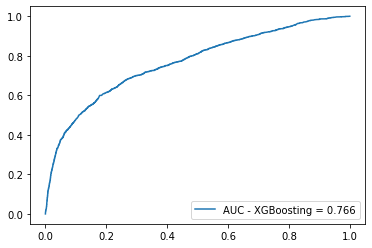

In [20]:
# Plot the precision recall curve # 4 pts

probTest = XGBmodel.predict_proba(x_test)
probTest = probTest[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, 
                                 probTest)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test, 
                             y_score = probTest),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

__________________

# Part 2: Feature importance and Interpretability (50 pts)

## Feature Importance (11 pts)

In this part, we compare the variable importance constructed by mean-gini and mean-shap values.

**Task 1:** plot the variable importance plot by Entropy. (4 pts)

**Task 2:** plot the variable importance plot by mean-shap value. (3 pts)

**Task 3:** discuss the differences and why do you think it happens. (4 pts)

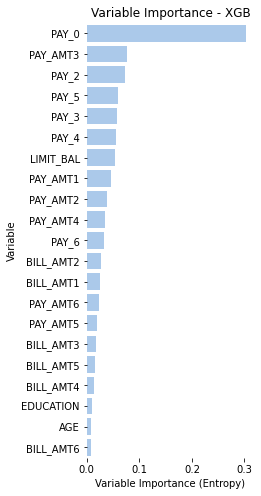

In [21]:
# Task 1: Variable importance using entropy measure #4 pts
importances = XGBmodel.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGB")
sns.set_color_codes("pastel")
sns.barplot(y=[x_train.columns[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


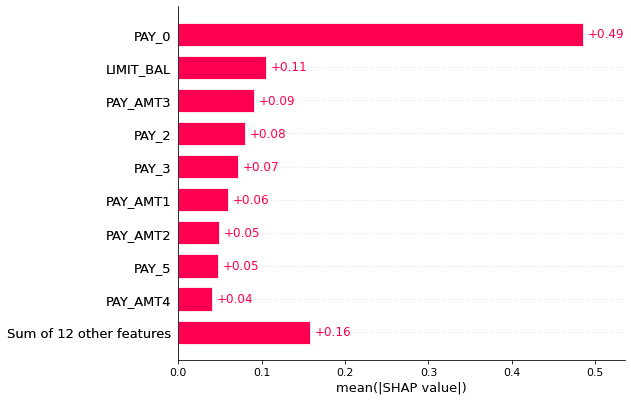

In [22]:
# Task 2: Variable importance by mean-shap values # 3 pts
explainer = shap.Explainer(XGBmodel)
shap_values = explainer(x_train)

shap.plots.bar(shap_values)

**Written Answer (4 pts)**: The most important feature stays the same but all the other ones change. LIMIT_BAL jumps up all the way to 2nd, and BILL_AMT1 also makes a large jump to 3rd. Other than the first most important, the whole ranking is almsot completely different. This difference is due to SHAP calcualting variable importance at a case level as oppose to the other one which calcualtes at a tree (global) level.

## Understanding and interpreting using SHAP values (39 pts)

**Task 1:** explain the model's predictions using SHAP for the first three cases in the dataset. What can you conclude from the feature contribution plot? (15 pts)

**Task 2:** Summarize the effects of all features by using a beeswarm plot. Report the first 3 features and interpret the results. (9 pts) 

**Task 3 :** For the variables "PAY_0","PAY_2" and "LIMIT_BAL", create a dependence scatter plot to show the effect of a single feature across the whole dataset and discuss the relationship between this feature its most highly correlated variable. (15 pts) 

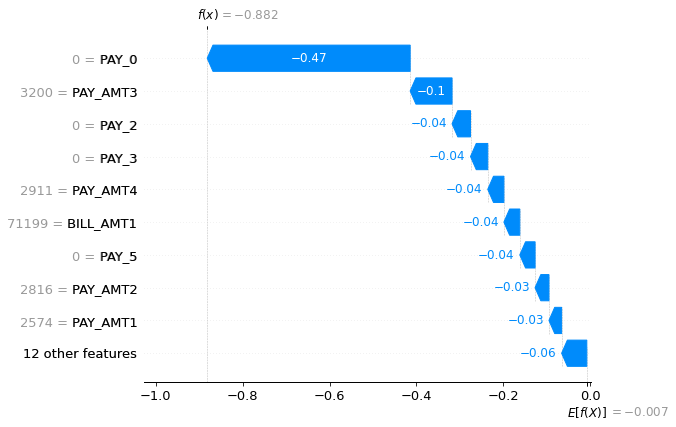

In [23]:
# Task 1:
# visualize the first prediction's explanation # 2 pts 
shap.plots.waterfall(shap_values[0])

**Written Answer (3 pts)**: Looking at the 9 features with highest contribution, this individual never had delayed payments, has a limit_bal high enough to correspond to a negative shap value, and has made large enough bill payments as well to merit negative shap values. Strongly conclude that they did not default.

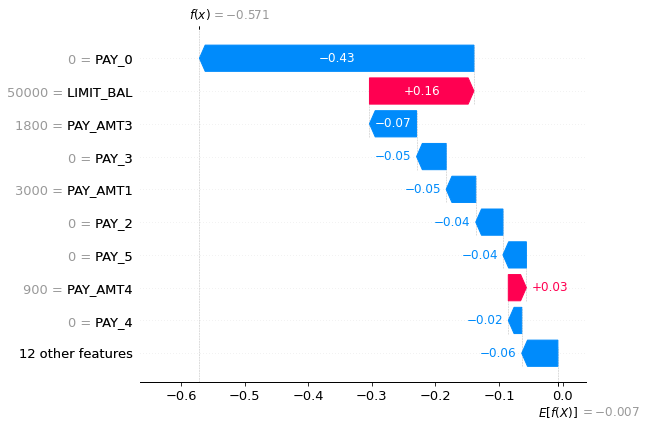

In [24]:
# visualize the second prediction's explanation # 2 pts
shap.plots.waterfall(shap_values[1])

**Written Answer (3 pts):** This individual has has very similar contribution variables as the first one. They also never had delayed payments. The difference is their PAY_AMT 2 was not large enough to merit a negative SHAP score. Still we strongly conclude that they did not default.

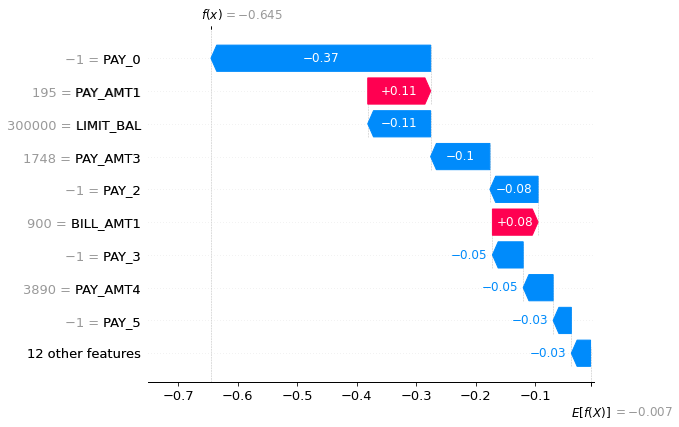

In [25]:
# visualize the third prediction's explanation # 2 pts
shap.plots.waterfall(shap_values[2])

**Written Answer (3 pts):** This individual has different contributing variables than the previous 2. They're LIMIT_BAL, being lower than the previous ones, has a much lesser contribution. They also never had delayed payments. However, they're PAY_AMT3 and PAY_AMT2 contribute a positive shap score. We still conclude that they did not default.

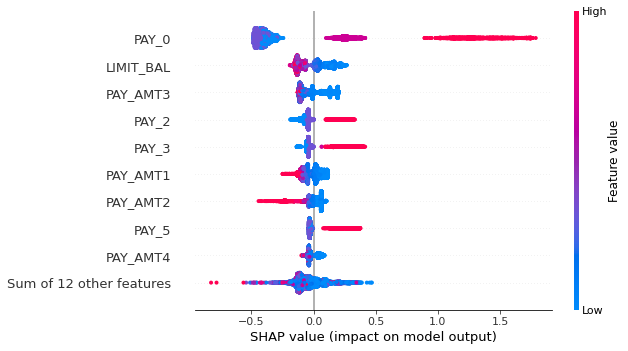

In [26]:
# Task 2: 
# summarize the effects of all the features # 3 pts
shap.plots.beeswarm(shap_values)

**Written Answer (6 pts)**: First 3 features: PAY_0, LIMIT_BAL, BILL_AMT1. A higher PAY_0 corresponds to a strong positive SHAP value that is evenly spread out, while low PAY_0, results in a weak negative, concentrated SHAP value. Having a high PAY_0 usually is a vary strong indication of being a defaulter. 
A lower LIMIT_BAL corresponds to a weak positive SHAP value while a higher LIMIT_BAL corresponds to a weak negative SHAP value. So having lower credit is an indicator of being a defaulter but it is relatively weak. The same for having higher credit score being an indicator of not defaulting. 
It seems that having a high BILL_AMT1 is not a good indicator of anything as the shap values are all close to zero. Having a low BILL_AMT1 could result in both weak negative or weak positive SHAP values thus being slight indicators for default or not defaulting.

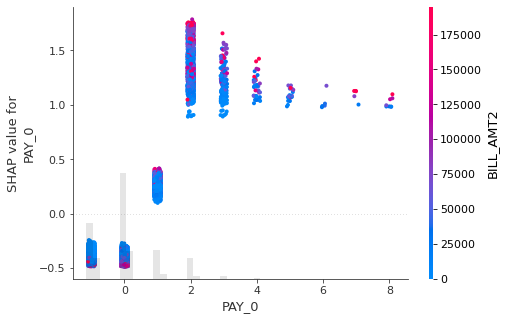

In [27]:
# Task 3:
# plot regarding PAY_0  # 2 pts
shap.plots.scatter(shap_values[:,"PAY_0"], color=shap_values)

**Written answer (3 pts):** Shap values for PAY_0 show clearly a non-linear contribution. 
Relation with PAY_3: The larger the value of PAY_0 , the larger the value of PAY_3 in general. (The larger the payment delay in September 2005, the larger the payment delay in August 2005.)

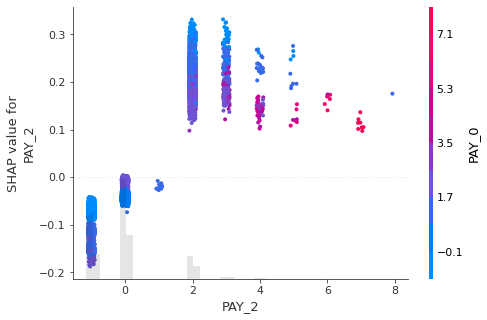

In [28]:
# plot regarding PAY_2 # 2pts
shap.plots.scatter(shap_values[:,"PAY_2"], color=shap_values)

**Written answer (3 pts):**
Shap values for PAY_2 show a clear non-linear contribution.
Relation with PAY_0: The larger the value of PAY_2 , the larger the value of PAY_0 in general. (The larger the payment delay in  2005, the larger the payment delay in September 2005.)



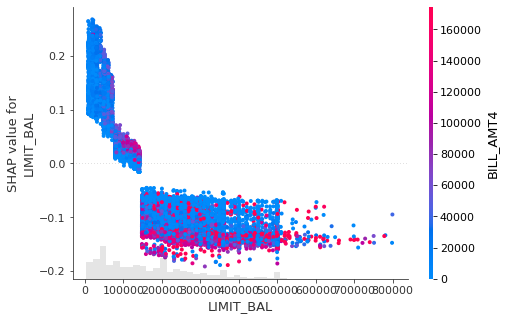

In [29]:
# plot regarding LIMIT_BAL # 2pts
shap.plots.scatter(shap_values[:,"LIMIT_BAL"], color=shap_values)

**Written answer (3 pts):**
Shap values for LIMIT_BAL show a clear non-linear contribution. This time the lower values of LIMIT_BAL correpond to a higher SHAP value. For the previous two graphs, it was the opposite.
Relation with PAY_0: A lower value of LIMIT_BAL corresponds to a higher value of PAY_0 in general. (The smaller the credit that is given, the larger the payment delay in September 2005.)

# Part 3: Confounding and fairness (19 pts)

**Task 1:** 

*   Create a scatterplot of Limit_Bal and Pay0, using Gender as the hue. (3 pts)
*   Can you identify any confounding factors in these relations? Describe any issues you can find within these two variables. *Respond in Written Answer 1*.(4 pts)

**Task 2:** 

With these results, answer the following questions: 


*   Assuming you want to achieve Gender fairness. How would the independence, separation and sufficiency criteria be achieved (i.e. what does this mean for this specific model and variables)? Can these three criteria be achieved simultaneously?. *Respond in Written answer 2*. (7 pts)
*   Considering your past answers, would you take any corrective actions in these models to achieve a fairer model? What would you think is necessary to correct?. *Respond in Written Answer 3*. (5 pts)


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


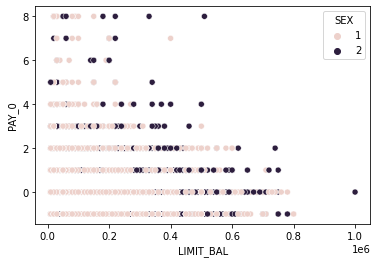

In [30]:
# Task 1:
# Pairplot #3 pts


sns.scatterplot(df.LIMIT_BAL, df.PAY_0, hue = df['SEX'])
plt.show()

**Written Answer 1 (4 pts):** There is confounding. Females tend to have larger credit balance, for all values of PAY_0. There is a different distribution for females than for males. 

**Written Answer 2 (7 pts):** Can achieve independence by interacting gender with the other variables. Can achieve seperation by choosing cut-off points for gender. Can also treat with PCA and eliminate the impact of the gender variable. These criteria cannot be all achieved simultaneously. 

**Written Answer 3 (5 pts):**

# **Follow These Steps Before Submitting**
**Once you are finished, ensure to complete the following steps**.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

5.  Your submission document should be saved in the form: `LastName_FirstName_Assignment9.ipynb`